### Mech Interp - Comparaing Qwen 2.5 Math and Deepseek-R1-Distill

### Setup and Installation

In [1]:
!pip install transformers>=4.30.0 torch>=2.0.0 einops plotly pandas scipy matplotlib tqdm -q

In [2]:
!pip install git+https://github.com/neelnanda-io/TransformerLens.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Imports

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from torch.nn.functional import kl_div
from tqdm import tqdm
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from scipy.stats import entropy
from transformer_lens import HookedTransformer
import html
import colorsys

### Load Model

In [4]:
qwen_model = AutoModelForCausalLM.from_pretrained(
    'Qwen/Qwen2.5-Math-1.5B',
    torch_dtype = torch.float16,
    device_map = 'auto'
)

qwen_tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-Math-1.5B')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [5]:
deepseek_model = AutoModelForCausalLM.from_pretrained(
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B',
    torch_dtype = torch.float16,
    device_map = 'auto'
)

deepseek_tokenizer = AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B')


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### Create Hooked Transformers

In [7]:
base_model = HookedTransformer.from_pretrained_no_processing(
    'Qwen/Qwen2.5-1.5B',
    hf_model = qwen_model
)

tuned_model = HookedTransformer.from_pretrained_no_processing(
    'Qwen/Qwen2.5-1.5B',
    hf_model = deepseek_model
)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer
Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer


In [8]:
base_model.tokenizer = deepseek_tokenizer
tuned_model.tokenizer = deepseek_tokenizer

In [9]:
print(tuned_model.to_str_tokens("Hello world! <think>"))

['<｜begin▁of▁sentence｜>', 'Hello', ' world', '!', ' ', '<think>']


### Define Special Tokens

In [10]:
BOS = 151646
THINK = 151648
END_THINK = 151649
ASSISTANT = 151645
USER = 151644

### Streaming Generation Functions

In [50]:
from transformer_lens import HookedTransformerKeyValueCache

def streaming_generate(
    model,
    input_text,
    max_new_tokens = 200,
    stop_at_eos = True,
    do_sample = False,
    top_k = None,
    temperature = 1.0,
    use_past_kv_cache = True,
    display_input = False,
    wrap_width = 80,
    highlight_newlines = False,
    stop_tokens = []
):

  """
  Generates tokens from the model and streams them to the console
  """

  if not isinstance(input_text, torch.Tensor):
    tokens = model.to_tokens(input_text)

  else:
    tokens = input_text
  device = model.cfg.device

  if display_input:
    input_str_tokens = model.to_str_tokens(input_text)
    print('Input: ', end = " ")
    for token in input_str_tokens:
      print(token, end = " ", flush = True)
    print()

  # Start with empty string for outputs
  generated_text = ""

  # create KV cache if needed:
  if use_past_kv_cache:
    past_kv_cache = HookedTransformerKeyValueCache.init_cache(
        model.cfg, device, batch_size = 1
    )

  else:
    past_kv_cache = None

  # for training line length for wrapping
  current_line_length = 0

  # Generate tokens one by one
  for i in range(max_new_tokens):
    with torch.no_grad():

      if i == 0:
        logits = model(
            tokens,
            return_type = 'logits',
            past_kv_cache = past_kv_cache
        )
        next_token_logits = logits[0, -1]


      else:
        logits = model(
            new_tokens,
            return_type = 'logits',
            past_kv_cache = past_kv_cache
        )
        next_token_logits = logits[0, -1]

    if do_sample:
      probs = torch.softmax(next_token_logits / temperature, dim=1)

      if top_k is not None:
        indices_to_remove = probs < torch.topk(probs, top_k)[0][-1]
        probs[indices_to_remove] = 0
        probs = probs / probs.sum()

      if top_p is not None:
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[0] = False
        indices_to_remove = sorted_indices_to_remove.scatter(
            0, sorted_indices, sorted_indices_to_remove
        )
        probs[indices_to_remove] = 0
        probs = probs / probs.sum()

      next_token = torch.multinomial(probs, 1).item()

    else:
      next_token = torch.argmax(next_token_logits).item()

    # Convert token to string and print
    next_token_str = model.tokenizer.decode([next_token])

    # Handle wrapping
    if wrap_width is not None:
        if '\n' in next_token_str:
            current_line_length = len(next_token_str.split('\n')[-1])
        else:
            current_line_length += len(next_token_str)

        if current_line_length > wrap_width:
            if highlight_newlines:
                print(" [↵]\n", end='', flush=True)
            else:
                print("\n", end='', flush=True)
            current_line_length = len(next_token_str)

    print(next_token_str, end='', flush=True)
    generated_text += next_token_str

    new_tokens = torch.tensor([[next_token]], device=device)

    if stop_at_eos and next_token == model.tokenizer.eos_token_id:
        break
    if next_token in stop_tokens:
        break


  print()

  if display_input:
      return model.to_string(tokens)[0] + generated_text # Convert the list of strings to a single string
  else:
      return generated_text

### Generate sample output

In [51]:
tokens = torch.cat([
    torch.tensor([USER]).cuda(),
    tuned_model.to_tokens("How many copies of the earth can fit inside the sun?")[:, 1:].squeeze(),
    torch.tensor([ASSISTANT, THINK]).cuda(),
])

In [52]:
print("Prompt tokens:", tuned_model.to_str_tokens(tokens))

Prompt tokens: ['<｜User｜>', 'How', ' many', ' copies', ' of', ' the', ' earth', ' can', ' fit', ' inside', ' the', ' sun', '?', '<｜Assistant｜>', '<think>']


In [53]:
input_string = tuned_model.to_string(tokens)
print("Input string for streaming:", input_string)
streaming_sample = streaming_generate(
    tuned_model,
    input_string,
    max_new_tokens = 3000, # Increased max_new_tokens
    do_sample = False,
    stop_at_eos = True,
    display_input = True,
    wrap_width = 60,
    highlight_newlines = True,
    stop_tokens = []
)

Input string for streaming: <｜User｜>How many copies of the earth can fit inside the sun?<｜Assistant｜><think>
Input:  <｜begin▁of▁sentence｜> <｜User｜> How  many  copies  of  the  earth  can  fit  inside  the  sun ? <｜Assistant｜> <think> 

Okay, so I need to figure out how many Earths can fit inside [↵]
 the Sun. Hmm, that's an interesting question. I guess I [↵]
 should start by understanding the sizes of both the Sun and [↵]
 Earth. I know the Sun is much larger than Earth, but how [↵]
 much larger exactly?

I remember that the Sun's diameter is about 1.39 million [↵]
 kilometers, and Earth's diameter is roughly 12,742 [↵]
 kilometers. So, if I divide the Sun's diameter by Earth's [↵]
 diameter, that should give me an idea of how many Earths [↵]
 could fit side by side in length. Let me do that [↵]
 calculation: 1,390,000 divided by 12,742. Hmm, that's [↵]
 approximately 109. So, that suggests that 109 Earths could [↵]
 fit along the diameter of the Sun. But wait, that's just [↵]
 the le

### Compute KL Divergence

In [54]:
rollout = tuned_model.to_tokens(streaming_sample)
rollout_str_tokens = tuned_model.to_str_tokens(rollout)

In [55]:
with torch.no_grad():
  base_logits = base_model(rollout, return_type='logits')
  tuned_logits = tuned_model(rollout, return_type='logits')

  rollout_kl_divergences = []
  for pos in range(base_logits.shape[1]):
    base_probs = torch.softmax(base_logits[0, pos], dim=-1)
    tuned_probs = torch.softmax(tuned_logits[0, pos], dim=-1)
    kl = kl_div(tuned_probs.log(), base_probs, reduction='sum')
    rollout_kl_divergences.append(kl.item())

print(f'Computed KL Divergence for {len(rollout_kl_divergences)} tokens')
print(f'Mean KL Divergence: {np.mean(rollout_kl_divergences):.4f}')
print(f'Max KL Divergence: {np.max(rollout_kl_divergences):.4f}')

Computed KL Divergence for 1008 tokens
Mean KL Divergence: 0.9443
Max KL Divergence: 22.9580


### Find Thinking Regions

In [56]:
think_positions = []
close_think_positions = []

for i, token_id in enumerate(rollout[0].tolist()):
  if token_id == THINK:
    think_positions.append(i)
    print(f"Found thinking marker at position {i}")
  elif token_id == END_THINK:
    close_think_positions.append(i)
    print(f"Found close thinking marker at position {i}")

Found thinking marker at position 16
Found close thinking marker at position 896


### Visualize KL Divergence

In [57]:
# Prepare hover texts
hover_texts = []
for i, (token, kl) in enumerate(zip(rollout_str_tokens, rollout_kl_divergences)):
    context_before = []
    for j in range(1, 4):
        if i-j >= 0:
            context_before.insert(0, rollout_str_tokens[i-j])

    context_after = []
    for j in range(1, 4):
        if i+j < len(rollout_str_tokens):
            context_after.append(rollout_str_tokens[i+j])

    context_text = " ".join(f"<span style='color:gray'>{t}</span>" for t in context_before)
    context_text += f" <span style='color:black;font-weight:bold'>{token}</span> "
    context_text += " ".join(f"<span style='color:gray'>{t}</span>" for t in context_after)

    hover_texts.append(
        f"<b>Position:</b> {i}<br>" +
        f"<b>Token:</b> {token}<br>" +
        f"<b>KL:</b> {kl:.4f}<br>" +
        f"<b>Context:</b> {context_text}"
    )

# Create basic line plot
fig = px.line(
    x=list(range(len(rollout_kl_divergences))),
    y=rollout_kl_divergences,
    labels={"x": "Token Position", "y": "KL Divergence"},
    title="KL Divergence Between Base and Tuned Models per Token"
)

# Add markers for thinking regions
for pos in think_positions:
    fig.add_vline(
        x=pos,
        line_dash="dash",
        line_color="green",
        annotation_text="THINK",
        annotation_position="top"
    )

for pos in close_think_positions:
    fig.add_vline(
        x=pos,
        line_dash="dash",
        line_color="red",
        annotation_text="END_THINK",
        annotation_position="top"
    )

fig.update_traces(
    hovertemplate="%{text}",
    text=hover_texts,
    line=dict(width=2, color='royalblue')
)

fig.update_layout(
    plot_bgcolor="rgba(240, 240, 240, 0.8)",
    paper_bgcolor="rgba(240, 240, 240, 0.8)",
    hovermode="x unified"
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white')

fig.show()

print(f"Debug: think_positions = {think_positions}")
print(f"Debug: close_think_positions = {close_think_positions}")
print(f"Debug: Condition is {bool(think_positions and close_think_positions)}")

# Create enhanced plot with shaded thinking region
if think_positions and close_think_positions:
    think_pos = think_positions[0]
    close_think_pos = close_think_positions[0]

    fig2 = go.Figure()

    fig2.add_trace(go.Scatter(
        x=list(range(len(rollout_kl_divergences))),
        y=rollout_kl_divergences,
        mode='lines',
        name='KL Divergence',
        line=dict(color='royalblue', width=2)
    ))

    fig2.add_trace(go.Scatter(
        x=[think_pos, think_pos, close_think_pos, close_think_pos],
        y=[0, max(rollout_kl_divergences)*1.1, max(rollout_kl_divergences)*1.1, 0],
        fill="toself",
        fillcolor="rgba(0,255,0,0.15)",
        line=dict(color="rgba(0,0,0,0)"),
        hoverinfo="skip",
        showlegend=False
    ))

    fig2.add_shape(
        type="line", line=dict(dash="dash", color="green", width=2),
        x0=think_pos, x1=think_pos, y0=0, y1=max(rollout_kl_divergences)*1.1
    )
    fig2.add_shape(
        type="line", line=dict(dash="dash", color="red", width=2),
        x0=close_think_pos, x1=close_think_pos, y0=0, y1=max(rollout_kl_divergences)*1.1
    )

    fig2.add_annotation(
        x=think_pos, y=max(rollout_kl_divergences)*1.1,
        text="THINK", showarrow=False,
        font=dict(size=14, color="green"),
        xanchor="center", yanchor="bottom"
    )
    fig2.add_annotation(
        x=close_think_pos, y=max(rollout_kl_divergences)*1.1,
        text="END_THINK", showarrow=False,
        font=dict(size=14, color="red"),
        xanchor="center", yanchor="bottom"
    )

    fig2.update_layout(
        title="KL Divergence with Highlighted Thinking Region",
        xaxis_title="Token Position",
        yaxis_title="KL Divergence",
        plot_bgcolor="rgba(240, 240, 240, 0.8)",
        paper_bgcolor="rgba(240, 240, 240, 0.8)",
        hovermode="x unified"
    )

    fig2.update_traces(
        hovertemplate="%{text}",
        text=hover_texts,
        selector=dict(name='KL Divergence')
    )

    fig2.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white')
    fig2.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white')

    fig2.show()

    # Calculate statistics
    thinking_kls = rollout_kl_divergences[think_pos:close_think_pos+1]
    non_thinking_kls = rollout_kl_divergences[:think_pos] + rollout_kl_divergences[close_think_pos+1:]

    print("\nKL Divergence Statistics:")
    print("-" * 80)
    print(f"Thinking region mean KL: {np.mean(thinking_kls):.4f}")
    print(f"Non-thinking region mean KL: {np.mean(non_thinking_kls):.4f}")
    print(f"Ratio (thinking/non-thinking): {np.mean(thinking_kls)/np.mean(non_thinking_kls):.4f}")


Debug: think_positions = [16]
Debug: close_think_positions = [896]
Debug: Condition is True



KL Divergence Statistics:
--------------------------------------------------------------------------------
Thinking region mean KL: 0.9425
Non-thinking region mean KL: 0.9570
Ratio (thinking/non-thinking): 0.9848


### Token-Level Analysis

In [59]:
analysis_df = pd.DataFrame()

In [60]:
for pos in range(len(rollout_str_tokens)):
  with torch.no_grad():
    token = rollout_str_tokens[pos]
    kl_value = rollout_kl_divergences[pos]

    base_probs = torch.softmax(base_logits[0, pos], dim=-1)
    tuned_probs = torch.softmax(tuned_logits[0, pos], dim=-1)

    base_entropy_val = entropy(base_probs.cpu().numpy())
    tuned_entropy_val = entropy(tuned_probs.cpu().numpy())

    if pos < len(rollout_str_tokens) - 1:
      next_token_id = rollout[0, pos + 1].item()
      base_logprob = torch.log(base_probs[next_token_id]).item()
      tuned_logprob = torch.log(tuned_probs[next_token_id]).item()

    else:
      base_logprob = float('nan')
      tuned_logprob = float('nan')

    analysis_df = pd.concat([analysis_df, pd.DataFrame([{
            'position': pos,
            'token': token,
            'kl_divergence': kl_value,
            'base_entropy': base_entropy_val,
            'tuned_entropy': tuned_entropy_val,
            'base_logprob': base_logprob,
            'tuned_logprob': tuned_logprob
        }])], ignore_index=True)

# Get top 10 tokens by KL divergence
top10_df = analysis_df.nlargest(10, 'kl_divergence')

In [61]:
print(top10_df[['position', 'token', 'kl_divergence', 'base_entropy', 'tuned_entropy']])

      position                token  kl_divergence  base_entropy  \
16          16              <think>      22.958019      6.635737   
15          15        <｜Assistant｜>      22.922621      3.491082   
1007      1007  <｜end▁of▁sentence｜>      22.696049      2.295772   
896        896             </think>      20.952812      8.687778   
895        895                  .\n      18.225349      2.972363   
23          23                   to      11.232986      3.657021   
75          75                ?\n\n      10.441356      8.189632   
17          17                   \n       9.374884      5.281092   
779        779                   't       8.668955      0.821643   
76          76                    I       7.892463      3.453243   

      tuned_entropy  
16     8.727273e-03  
15     1.786955e-06  
1007   2.628910e-07  
896    3.856249e-05  
895    4.770842e-05  
23     9.350323e-03  
75     1.446170e+00  
17     4.959230e-01  
779    1.183435e+00  
76     1.915719e-01  


### Entropy Vs KL Scatter plot

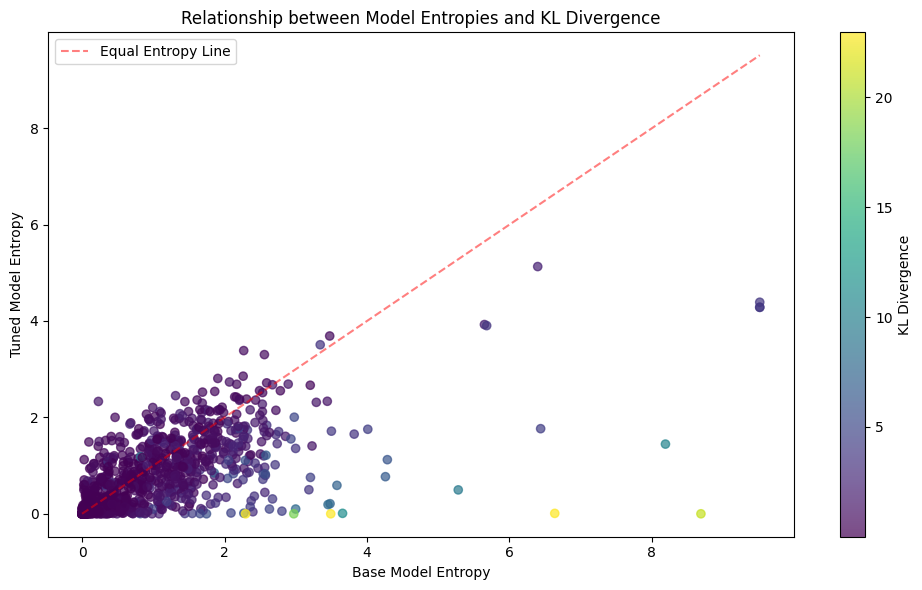

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['base_entropy'], analysis_df['tuned_entropy'],
            c=analysis_df['kl_divergence'], cmap='viridis', alpha=0.7)
plt.colorbar(label='KL Divergence')
plt.xlabel('Base Model Entropy')
plt.ylabel('Tuned Model Entropy')
plt.title('Relationship between Model Entropies and KL Divergence')
plt.plot([0, analysis_df['base_entropy'].max()], [0, analysis_df['base_entropy'].max()],
         'r--', alpha=0.5, label='Equal Entropy Line')
plt.legend()
plt.tight_layout()
plt.show()